In [70]:
import os
import sys
import warnings
from math import log10
warnings.filterwarnings("ignore")

sys.path.append('/home/ubuntu2/predict_future_sales_kaggle/src')

import cudf
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf

from sales_project.aggregations import aggregate
from sales_project.encoders import encode, target_encoder
from sales_project.clustering import agglomerative_clustering
from sales_project.plotters import linear_plot, decomposition_plot
from sales_project.utils import iqr_filter, clean_string, reduce_size

pd.set_option('display.max_rows', 100)

sns.set_theme(context='talk', style="darkgrid", palette='dark', font='sans-serif')
tqdm.pandas()

# I

## 1. Reading data

In [2]:
dataframes = {}
for name in tqdm(os.listdir("../data/raw")):
    if name.endswith(".csv"):
        df_name = name.split(".")[0]
        dataframes[df_name] = cudf.read_csv(f"../data/raw/{name}")

  0%|          | 0/6 [00:00<?, ?it/s]

## 2. Some initial preprocessing

In [3]:
dataframes['sales_train'].info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype
---  ------          -----
 0   date            object
 1   date_block_num  int64
 2   shop_id         int64
 3   item_id         int64
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 151.2+ MB


In [4]:
dataframes['test'].info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


It can be seen, that date feature is not yet in the appropriate data type  
Converting to datetime

In [5]:
df = dataframes['sales_train']
df['date'] = cudf.to_datetime(df['date'], format='%d.%m.%Y')

## 3. Duplicates

Dropping duplicates based on shop_id, item_id and date

In [6]:
number_of_unique_obs = len(df.drop_duplicates(subset=['shop_id', 'item_id', 'date']))
print(f"Number of obsrevations: {len(df)}")
print(f"Number of unique observations: {number_of_unique_obs}")
print(f"'Number of duplicates: {len(df)-number_of_unique_obs}")
print(f"Duplicates rate: {1-(number_of_unique_obs/len(df))}")

Number of obsrevations: 2935849
Number of unique observations: 2935821
'Number of duplicates: 28
Duplicates rate: 9.537275248105992e-06


There are very few duplicates in the train dataset, so better to just drop them

In [7]:
df.drop_duplicates(subset=['shop_id', 'item_id', 'date'], inplace=True)

## 4. Missing values

In [8]:
for col in df.columns:
    print(f"{col}: {df[col].isnull().sum()}")

date: 0
date_block_num: 0
shop_id: 0
item_id: 0
item_price: 0
item_cnt_day: 0


There are no missing values in the train dataset.

## 5. Outliers

### 1. Min and Max values

#### item_price

In [9]:
df['item_price'].describe()

count    2.935821e+06
mean     8.908562e+02
std      1.729807e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [10]:
df[df['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


There is one observation with a negative item_price.  
Let's fill the value with a median value calculated for the corresponding shop_id and item_id and data_block_num

In [11]:
df_ = df[(df['item_id']==2973) & (df['shop_id']==32) & (df['date_block_num']==4) & (df['item_price']>=0)]
df_

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,2013-05-23,4,32,2973,1249.0,1.0
484684,2013-05-06,4,32,2973,2499.0,1.0


In [12]:
df.loc[df.item_price < 0, 'item_price'] = df_['item_price'].median()

#### item_cnt_day

In [13]:
df['item_cnt_day'].describe()

count    2.935821e+06
mean     1.242644e+00
std      2.618846e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [14]:
df_ = df[df['item_cnt_day'] < 0]
print('Number of observations with negative item_cnt_day: ', len(df_))
print('Relative number of observations with negative item_cnt_day: ', len(df_)/len(df))

Number of observations with negative item_cnt_day:  7354
Relative number of observations with negative item_cnt_day:  0.0025049211106535447


There are a lot observations with a negative item_cnt_day  
It is likely that -1 means that the item was not sold at all  
But since the amount of them are very low comparing to the total number of observations  
it would be just better to drop those observations  

In [15]:
df.drop(df[df['item_cnt_day'] < 0].index, axis=0, inplace=True)

### 2. Boxplots

#### item_price

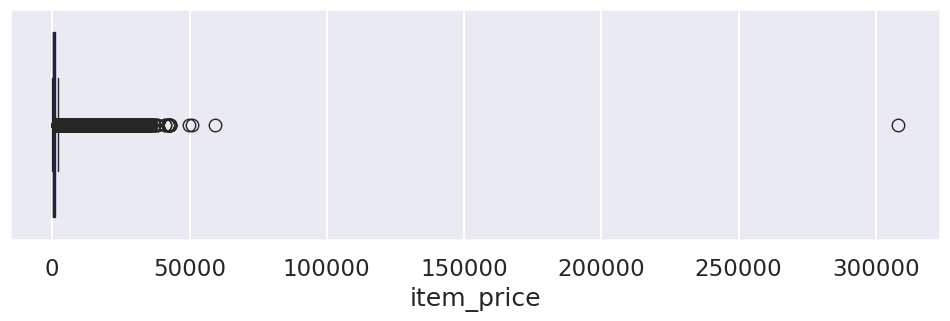

In [16]:
plt.figure(figsize=(12, 3))
sns.boxplot(df['item_price'].to_pandas(), orient='h')
plt.show()

It is a good practice for such distributions and for 'price' feature to apply log1p function

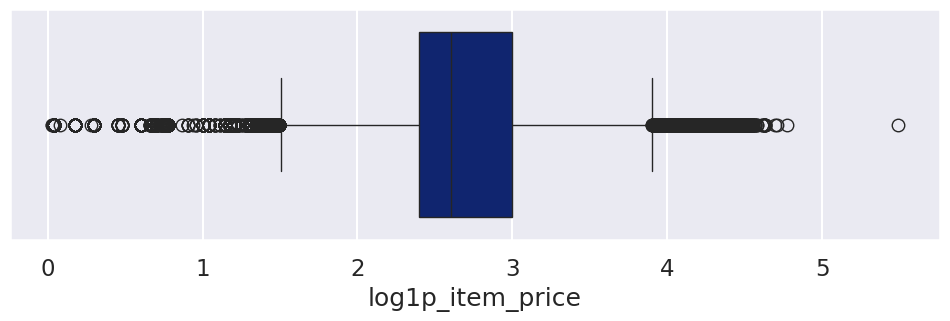

In [17]:

df['log1p_item_price'] = df['item_price'].apply(lambda x: log10(1 + x))
plt.figure(figsize=(12, 3))
sns.boxplot(df['log1p_item_price'].to_pandas(), orient='h')
plt.show()

The distribution looks more normal now.  
Since the amount of data is too big, Shapiro-Wilk Test won't be that useful  
Let's use qq plot

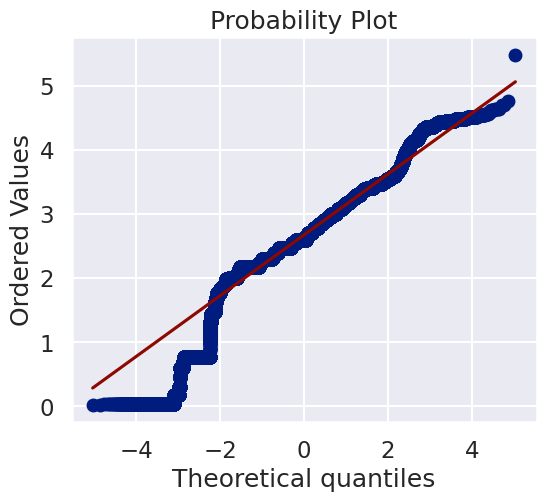

In [18]:
plt.figure(figsize=(6, 5))
stats.probplot(df['log1p_item_price'].to_pandas(), dist="norm", plot=plt)
plt.show()

It can be seen that the qq plot is more or less aligned with the normal distribution line  
only in the middle part while having strong skewness in the left and right parts.  
Let's apply IQR filtering to drop outliers and then check for normality

In [19]:
iqr_filter(df, feature='log1p_item_price', k=1.5)

Initial number of observations: 2928467
Number of observations after IQR filtering along feature "log1p_item_price": 2853838
Number of observations dropped: 74629
Drop rate: 0.025483981892232332


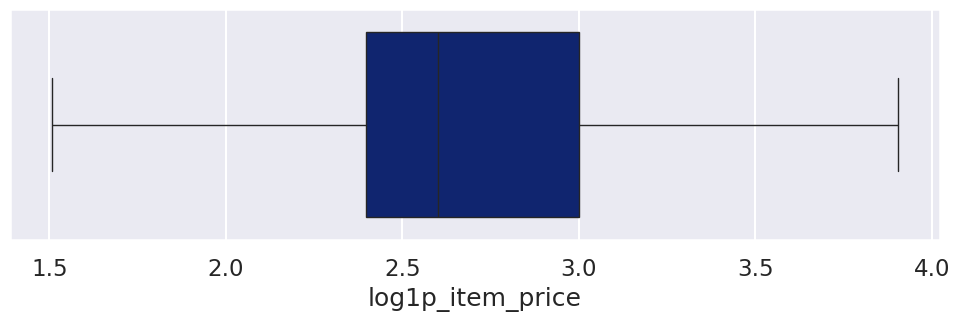

In [20]:
plt.figure(figsize=(12, 3))
sns.boxplot(df['log1p_item_price'].to_pandas(), orient='h')
plt.show()

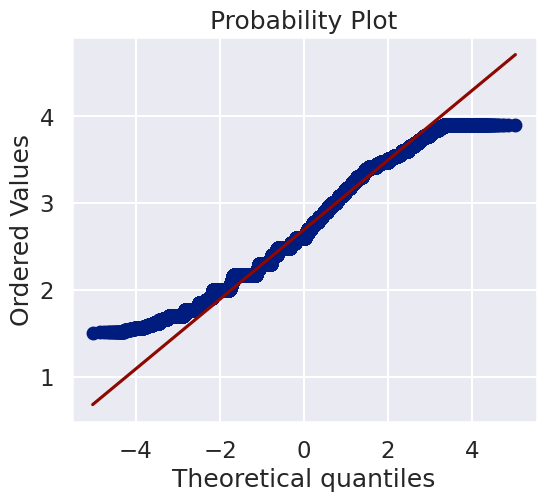

In [21]:
plt.figure(figsize=(6, 5))
stats.probplot(df['log1p_item_price'].to_pandas(), dist="norm", plot=plt)
plt.show()

The situation didn't change much if to consider normality  
As a result, about 2.5% of observations have been dropped   
If to consider the item_price directly, more data would have been dropped. 

#### item_cnt_day

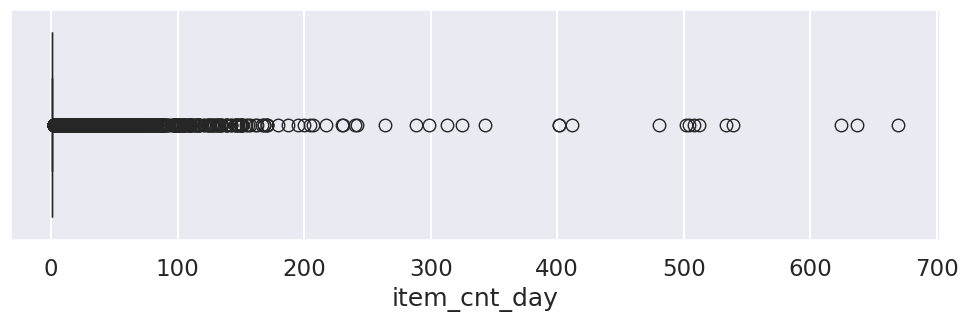

In [22]:
plt.figure(figsize=(12, 3))
sns.boxplot(df['item_cnt_day'].to_pandas(), orient='h')
plt.show()

In [23]:
df['item_cnt_day'].value_counts().sort_values(ascending=False).head(10)

item_cnt_day
1.0     2586892
2.0      184350
3.0       41873
4.0       15891
5.0        7798
6.0        4452
7.0        2689
8.0        1915
9.0        1338
10.0       1155
Name: count, dtype: int64

It seems that for this feature it is also good to apply log1p  
but it is not because there are significant amount of data with the same value (1)  
Therefore let's just filter out outliers using a threshold of 200.

In [24]:
prev_len = len(df)
df = df[(df['item_cnt_day'] <= 200)]
print('Number of observations after filtering: ', len(df))
print('Number of dropped observations: ', prev_len-len(df))
print('Drop rate: ', 1-len(df)/prev_len)

Number of observations after filtering:  2853812
Number of dropped observations:  26
Drop rate:  9.110538159440296e-06


Very few observations have been dropped

#### item_revenue_day (new feature)

New feature: item_revenue_day = item_price * item_cnt_day

In [25]:
df['item_revenue_day'] = df['item_price'] * df['item_cnt_day']

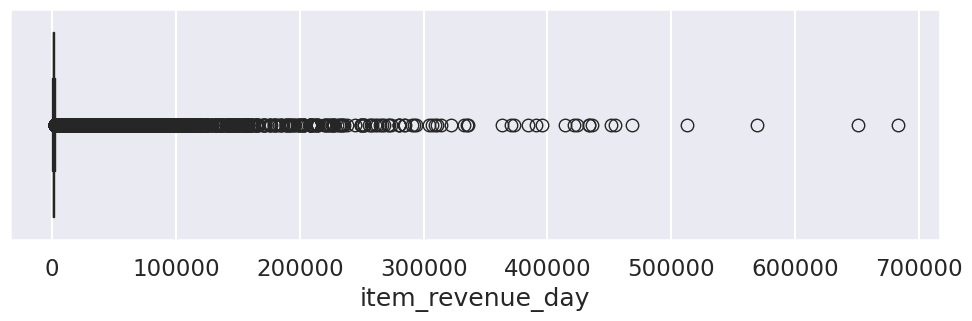

In [26]:
plt.figure(figsize=(12, 3))
sns.boxplot(df['item_revenue_day'].to_pandas(), orient='h')
plt.show()

Lets apply log1p as in the case of item_price

In [27]:
df['log1p_item_revenue_day'] = df['item_revenue_day'].apply(lambda x: log10(1 + x))

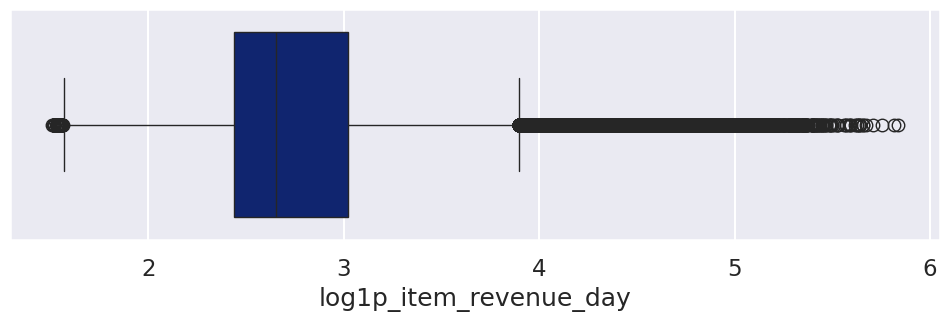

In [28]:
plt.figure(figsize=(12, 3))
sns.boxplot(df['log1p_item_revenue_day'].to_pandas(), orient='h')
plt.show()

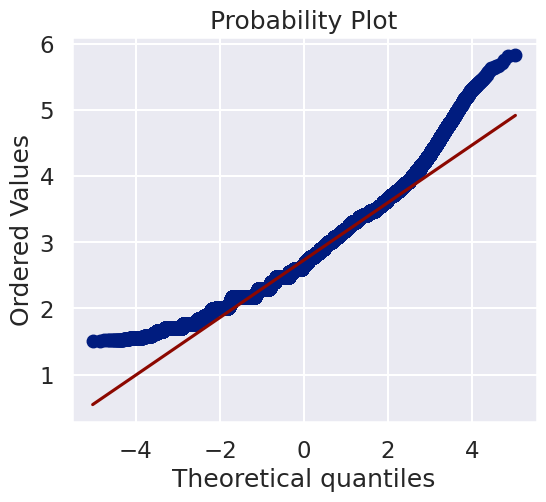

In [29]:
plt.figure(figsize=(6, 5))
stats.probplot(df['log1p_item_revenue_day'].to_pandas(), dist="norm", plot=plt)
plt.show()

Not suprisingly, the distribution is far from normal with a heavy rigth tail  
Let's apply iqr filtering

In [30]:
iqr_filter(df, feature='log1p_item_revenue_day', k=1.5)

Initial number of observations: 2853812
Number of observations after IQR filtering along feature "log1p_item_revenue_day": 2832631
Number of observations dropped: 21181
Drop rate: 0.007422002570596775


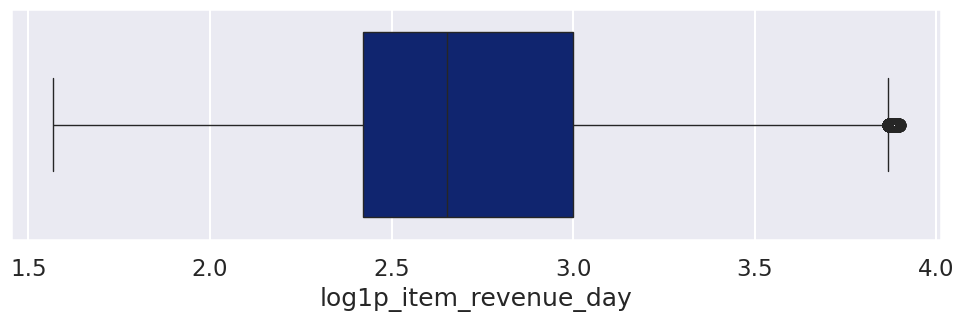

In [31]:
plt.figure(figsize=(12, 3))
sns.boxplot(df['log1p_item_revenue_day'].to_pandas(), orient='h')
plt.show()

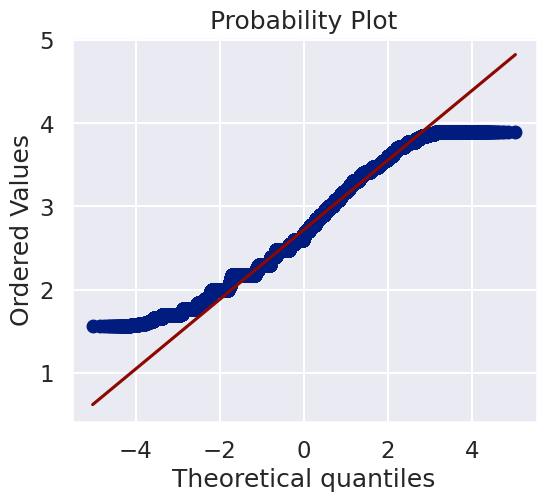

In [32]:
plt.figure(figsize=(6, 5))
stats.probplot(df['log1p_item_revenue_day'].to_pandas(), dist="norm", plot=plt)
plt.show()

The resulting distribution is similar to item_price case  
What is more important, that very few observations have been dropped  
which were outliers

## 6. Data regrouping

In [33]:
n_combinations = 0
for block_num in df['date_block_num'].to_pandas().unique():
    n_shops = df.loc[df['date_block_num'] == block_num, 'shop_id'].nunique()
    n_items = df.loc[df['date_block_num'] == block_num, 'item_id'].nunique()
    n_dates = 30.5
    n_combinations += n_shops * n_items * n_dates

print(f'Number of combinations stored: {len(df)}')
print(f'Number of (item_id, shop_id, date) unique combinations for each date_block_num: {n_combinations}')
print(f'Ratio: {len(df)/n_combinations}')

Number of combinations stored: 2832631
Number of (item_id, shop_id, date) unique combinations for each date_block_num: 323370333.0
Ratio: 0.008759712041982528


In [34]:
print(f"Number of observations with zero item_cnt_day: {len(df[df['item_cnt_day']==0])}")

Number of observations with zero item_cnt_day: 0


There are a lot of missing data for a lot of dates for (item_id, shop_id, date) combination  
for each date_block_num.  
Probably, for a pair (item_id, shop_id) with no data for some date, it was assumed that  
0 items were sold at that date (item_cnt_day = 0) - to prove it more just see that there is  
no observations with item_cnt_day = 0.   
Therefore it is right to fill in missing data with 0 for item_cnt_day, but it would be 99 %  
data with 0 for item_cnt_day, which would lead to too sparse density.  
Since that fact and that the task is to predict the sales for the next month, it is better  
to consider month block instead of a date

Let's create a dataframe where it would be possible to store all possible combinations  
of (shop_id, item_id, date_block_num) for a given date_block_num

In [35]:
from itertools import product

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in df['date_block_num'].to_pandas().unique():
    cur_shops = df.loc[df['date_block_num'] == block_num, 'shop_id'].to_pandas().unique()
    cur_items = df.loc[df['date_block_num'] == block_num, 'item_id'].to_pandas().unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = cudf.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = grid.set_index(index_cols)

Since the data will be aggregated, some different features can be obtained.

For feature item_cnt_day:  
- item_cnt_month - the number of sold $item\_id$ items in the shop $shop\_id$  
  in month block $date\_block\_num$. This will the target feature 

For feature item_price:  
- item_price_month_mean
  
For feature log1p_item_price:  
- item_log1p_price_month_mean

For feature item_revenue_day:  
- item_revenue_month
- item_revenue_month_mean
  
For feature log1p_item_revenue_day:  
- item_log1p_price_month_mean

In [36]:
aggregations = {
    'item_cnt_day': ['sum'],
    'item_price': ['mean'],
    'log1p_item_price': ['mean'],
    'item_revenue_day': ['sum', 'mean'],
    'log1p_item_revenue_day': ['mean']
}

df_monthly = df.groupby(index_cols).agg(aggregations)
df_monthly.columns = [v[0]+'_'+v[1] for v in df_monthly.columns]
df_monthly.rename(columns={
    'item_cnt_day_sum': 'item_cnt_month',
    'item_revenue_day_sum': 'item_revenue_month',
    'item_revenue_day_mean': 'item_revenue_month_mean',
    'log1p_item_revenue_day_mean': 'log1p_item_revenue_month_mean',
    },
    inplace=True)

Merging grouped data with the grid

In [37]:
df_monthly = grid.join(df_monthly, how='left')

In [38]:
print(f'Number of (item_id, shop_id, date_block_num) combinations in data : {len(df_monthly)}')
print(f"Number of (item_id, shop_id, date_block_num) combinations with missing data : {len(df_monthly[df_monthly['item_cnt_month'].isnull()])}")
print(f"No nans data ratio: {1-len(df_monthly[df_monthly['item_cnt_month'].isnull()])/len(df_monthly)}")

Number of (item_id, shop_id, date_block_num) combinations in data : 10602306
Number of (item_id, shop_id, date_block_num) combinations with missing data : 9018511
No nans data ratio: 0.14938212498299897


About 85% of data is missing which is a lot better  
Now, let's fill in missing data with 0 for the reason discussed above

In [39]:
df_monthly.fillna(0, inplace=True)
df_monthly.reset_index(inplace=True)

Let's append test data to the dataset

In [40]:
dataframes['test'].drop('ID', axis=1, inplace=True)
df_monthly = cudf.concat([df_monthly, dataframes['test']], axis=0).reset_index(drop=True)

# Setting date_block_num for the test subset to 34 (which is the next month block
# which is the last month block of the training set)
df_monthly['date_block_num'].fillna(df_monthly['date_block_num'].max()+1, inplace=True)

Now, let's add item_category_id to the data

In [41]:
df = df.merge(
    dataframes['items'][['item_id', 'item_category_id']], 
    on='item_id', 
    how='left'
)

df_monthly = df_monthly.merge(
    dataframes['items'][['item_id', 'item_category_id']], 
    on='item_id', 
    how='left'
)

## 7. Time series analysis

In [63]:
grouped = (
    df_monthly
    .query('date_block_num != 34')
    .groupby('date_block_num')
    .agg({'item_cnt_month': 'sum'})
    .sort_index()
    .to_pandas()
)

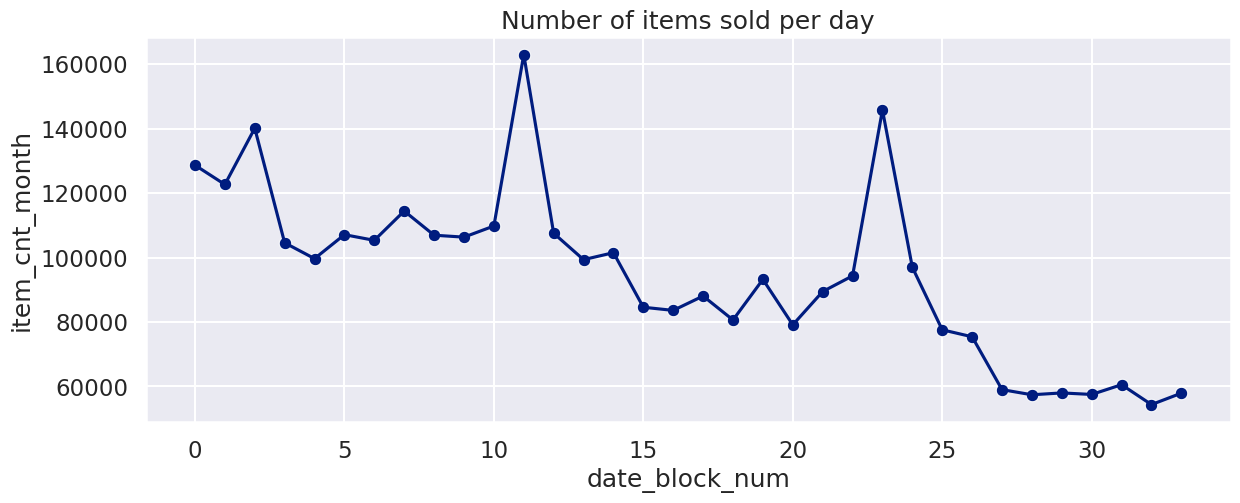

In [64]:
linear_plot(
    data=grouped,
    x="date_block_num",
    y="item_cnt_month",
    title="Number of items sold per day",
    use_index=True,
    scatter=True
)

- There is clear declining trend
- There are several seasonalities, like year-wise and season-wise

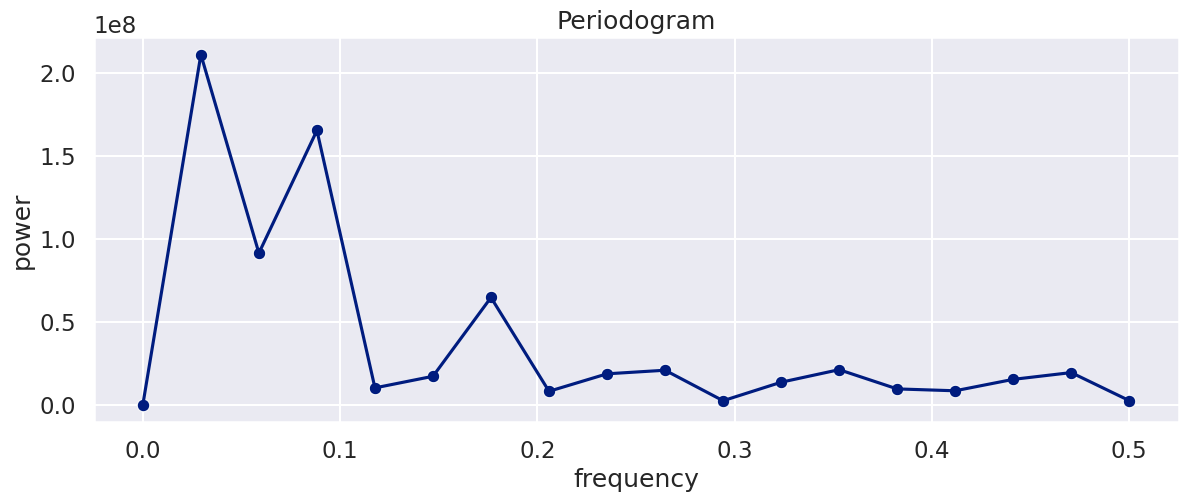

,frequency,power,period
1,0.029412,2.111680e+08,34.000000
3,0.088235,1.653874e+08,11.333333
2,0.058824,9.140432e+07,17.000000
6,0.176471,6.461802e+07,5.666667
12,0.352941,2.105898e+07,2.833333
9,0.264706,2.072610e+07,3.777778
16,0.470588,1.930595e+07,2.125000
8,0.235294,1.856415e+07,4.250000
5,0.147059,1.706860e+07,6.800000
15,0.441176,1.521432e+07,2.266667


In [65]:
frequencies, spectrum = periodogram(grouped['item_cnt_month'], scaling='spectrum')
freqs_df = pd.DataFrame({'frequency': frequencies, 'power': spectrum})
freqs_df['period'] = 1/freqs_df['frequency']
linear_plot(
    data=freqs_df, 
    x='frequency', 
    y='power', 
    title='Periodogram', 
    use_index=False,
    scatter=True
)
freqs_df.sort_values(by='power', ascending=False)

According to periodogram, the following lags (rounded) are significant if to compare power values:  
- 34 month - not appropriate to consider since only 34 month time span is considered
- 12 month - 
- 17 month - not appropriate to consider since only 34 month time span is considered
- 6 month
- 3 month
- 4 month
- 2 month
- 7 month
- 9 month
- 5 month

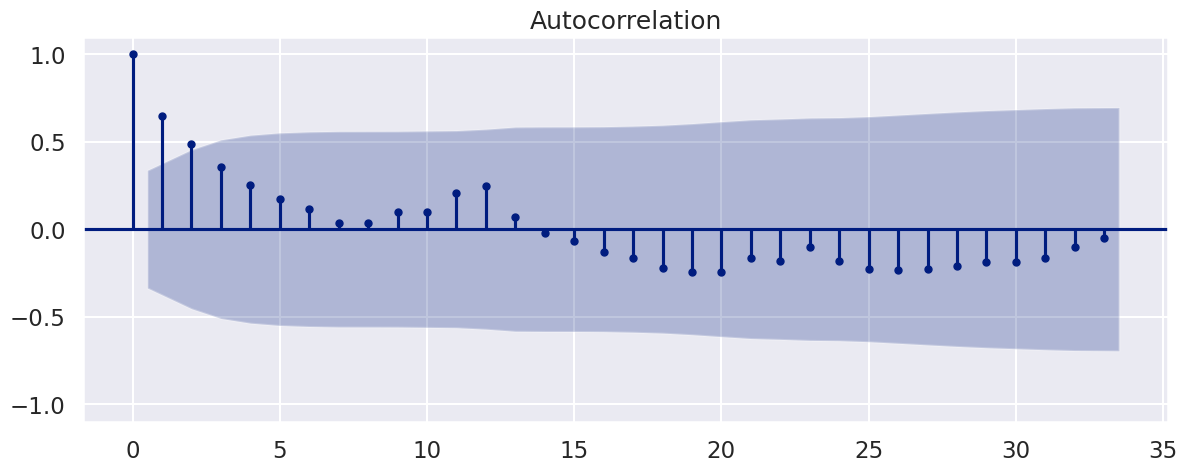

In [69]:
fig, ax = plt.subplots(figsize=(14, 5))
plot_acf(grouped['item_cnt_month'], lags=33, ax=ax, alpha=0.05)
plt.ylim(-1.1, 1.1)
plt.show()

According to autocorrelation plot, only 1 month and 2 month lags are significant, which  
is not a surprise since the timestpan considered is quite small to have lags like 6 month  
to be significant

Nevertheless, let's consider the following lags:
- 1 month
- 2 month
- 3 month

As for larger seasonalities, like 12 month (which is important according to periodogram)  
will be considered as a window for a rolling aggregation

## 8. More price-related features

In [44]:
df_monthly.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'item_price_mean', 'log1p_item_price_mean', 'item_revenue_month',
       'item_revenue_month_mean', 'log1p_item_revenue_month_mean',
       'item_category_id'],
      dtype='object')

In this section, new features are introduced:  
- norm_diff_cat_price: the normalized difference between the mean price of the item and  
the mean price of the corresponding category for each date_block_num
- norm_diff_cat_revenue: the normalized difference between the mean revenuew of the item and  
the mean revenue of the corresponding category for each date_block_num  
- norm_diff_cat_log1p_price: the normalized difference between the log1p of the mean price of the item and  
the mean log1p price of the corresponding category for each date_block_num  
- norm_diff_cat_log1p_revenue: the normalized difference between the log1p of the mean revenue of the item and  
the mean log1p revenue of the corresponding category for each date_block_num

Finally, the lag feature is calculated for the following features: 
- item_price
- item_revenue_day
- log1p_item_price
- log1p_item_revenue_day
- norm_diff_cat_price
- norm_diff_cat_revenue
- norm_diff_cat_log1p_price
- norm_diff_cat_log1p_revenue

The lag feature is calculated using the 'last' aggregation grouping by date_block_num and item_id

In [45]:
price_features = (
    df.groupby(["date_block_num", "item_id"])
    .agg({
        "item_price": "mean",
        "item_revenue_day": "mean",
        "log1p_item_price": "mean",
        "log1p_item_revenue_day": "mean",
        "item_category_id": 'last'
    })
    .reset_index()
)

features = {
        "item_price": "cat_price",
        "item_revenue_day": "cat_revenue",
        "log1p_item_price": "cat_log1p_price",
        "log1p_item_revenue_day": "cat_log1p_revenue"
}

mean_price_features = (
    price_features
    .groupby(["date_block_num", "item_category_id"])
    .agg({
        "item_price": "mean",
        "item_revenue_day": "mean",
        "log1p_item_price": "mean",
        "log1p_item_revenue_day": "mean",
    })
    .reset_index()
    .rename(columns=features)
)
price_features = (
    price_features
    .merge(
        mean_price_features, 
        how="left", 
        on=["date_block_num", "item_category_id"]
        )
)

for (k, v) in features.items():
    price_features[f'norm_diff_{v}'] = (
        price_features[k] - price_features[v]
    ) / price_features[v]

price_features.drop(['item_category_id'] + list(features.values()), axis=1, inplace=True)

features = [k for k in price_features if k not in ['date_block_num', 'item_id']]
newnames = ["last_" + f for f in features]
aggs = {f: "last" for f in features}
renames = {f: "last_" + f for f in features}
features = []
for dbn in range(1, 35):
    f_temp = (
        price_features.query(f"date_block_num<{dbn}")
        .groupby("item_id")
        .agg(aggs)
        .rename(columns=renames)
    )
    f_temp["date_block_num"] = dbn
    features.append(f_temp)
features = cudf.concat(features).reset_index()

df_monthly = df_monthly.merge(features, on=["date_block_num", "item_id"], how="left")

In [46]:
df_monthly

,shop_id,item_id,date_block_num,item_cnt_month,item_price_mean,log1p_item_price_mean,item_revenue_month,item_revenue_month_mean,log1p_item_revenue_month_mean,item_category_id,last_item_price,last_item_revenue_day,last_log1p_item_price,last_log1p_item_revenue_day,last_norm_diff_cat_price,last_norm_diff_cat_revenue,last_norm_diff_cat_log1p_price,last_norm_diff_cat_log1p_revenue
0,59,1932,0,0.0,0.0,0.0,0.0,0.0,0.0,19,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,59,10825,0,0.0,0.0,0.0,0.0,0.0,0.0,37,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,59,9297,0,0.0,0.0,0.0,0.0,0.0,0.0,62,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,59,7694,0,0.0,0.0,0.0,0.0,0.0,0.0,40,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,59,8649,0,0.0,0.0,0.0,0.0,0.0,0.0,40,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10816501,45,19772,34,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,37,249.0,249.0,2.397940009,2.397940009,-0.314609752,-0.338211182,-0.024622157,-0.027404308
10816502,45,20677,34,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,72,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
10816503,45,20196,34,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,49,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
10816504,45,17468,34,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,37,299.0,299.0,2.477121255,2.477121255,-0.176981189,-0.205321861,0.007585335,0.004711316


## 9. Dealing with item_name

Though item_name feature can be direcrtly encoded using some encoders or  
target encoding, it is good practice to transform such feature in order to  
extract new categorical features with less unique values. Later this features  
can also be treated as the original one.  

In the code below, a new categorical feature item_name_group is derived  
via fuzz

In [47]:
import re

from fuzzywuzzy import fuzz

def partialmatchgroups(items, sim_thresh: int):

    def strip_brackets(string):
        string = re.sub(r"\(.*?\)", "", string)
        string = re.sub(r"\[.*?\]", "", string)
        return string

    items["nc"] = items.item_name.apply(strip_brackets)
    items["ncnext"] = items["nc"].shift(-1)

    def partialcompare(s):
        return fuzz.partial_ratio(s["nc"], s["ncnext"])

    items["partialmatch"] = items.apply(partialcompare, axis=1)

    # Assign groups
    grp = 0
    for i in range(items.shape[0]):
        items.loc[i, "partialmatchgroup"] = grp
        if items.loc[i, "partialmatch"] < sim_thresh:
            grp += 1
    items = items.drop(columns=["nc", "ncnext", "partialmatch"])
    items.rename(columns={"partialmatchgroup": 'item_name_group'}, inplace=True)
    items['item_name_group'] = items['item_name_group'].apply(int)
    return items

items = partialmatchgroups(dataframes['items'].to_pandas(), 65)

It is also a good practice to use the length of a categorical string-like feature.  
In this case, we can use the length of the product name to predict the sales.

What is important, that item_name feature consists of quite polluted strings.  
Therefore, the it is better to calculate the length for both raw and preprocessed strings.  

In [48]:
items["item_name_cleaned_length"] = items["item_name"].apply(clean_string).apply(len)
items["item_name_length"] = items["item_name"].apply(len)

Let's encode item_name using BERT and then downsize the embedding using TSNE

In [49]:
items = cudf.from_pandas(items)

In [50]:
items = encode(
    df=items,
    column="item_name",
    perplexity=100,
    n_components=2,
    is_gpu_accelerated=True,
    tsne_method="fft",
)

[D] [12:40:58.550355] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:71 Data size = (22170, 384) with dim = 2 perplexity = 100.000000
[W] [12:40:58.550476] Perplexity should be within ranges (5, 50). Your results might be a bit strange...
[W] [12:40:58.550484] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[D] [12:40:58.550493] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:109 Getting distances.
[D] [12:40:58.757872] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:144 Now normalizing distances so exp(D) doesn't explode.
[D] [12:40:58.782009] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:152 Searching for optimal perplexity via bisection search.
[D] [12:41:01.110787] /opt/conda/conda-bld/work/python/build/cp311-cp311-linux_x86_64/cuml/internals/logger.cxx:5268 [t-SNE] KL divergence: 0.18102751672267914


<Axes: xlabel='item_name_emb_0', ylabel='item_name_emb_1'>

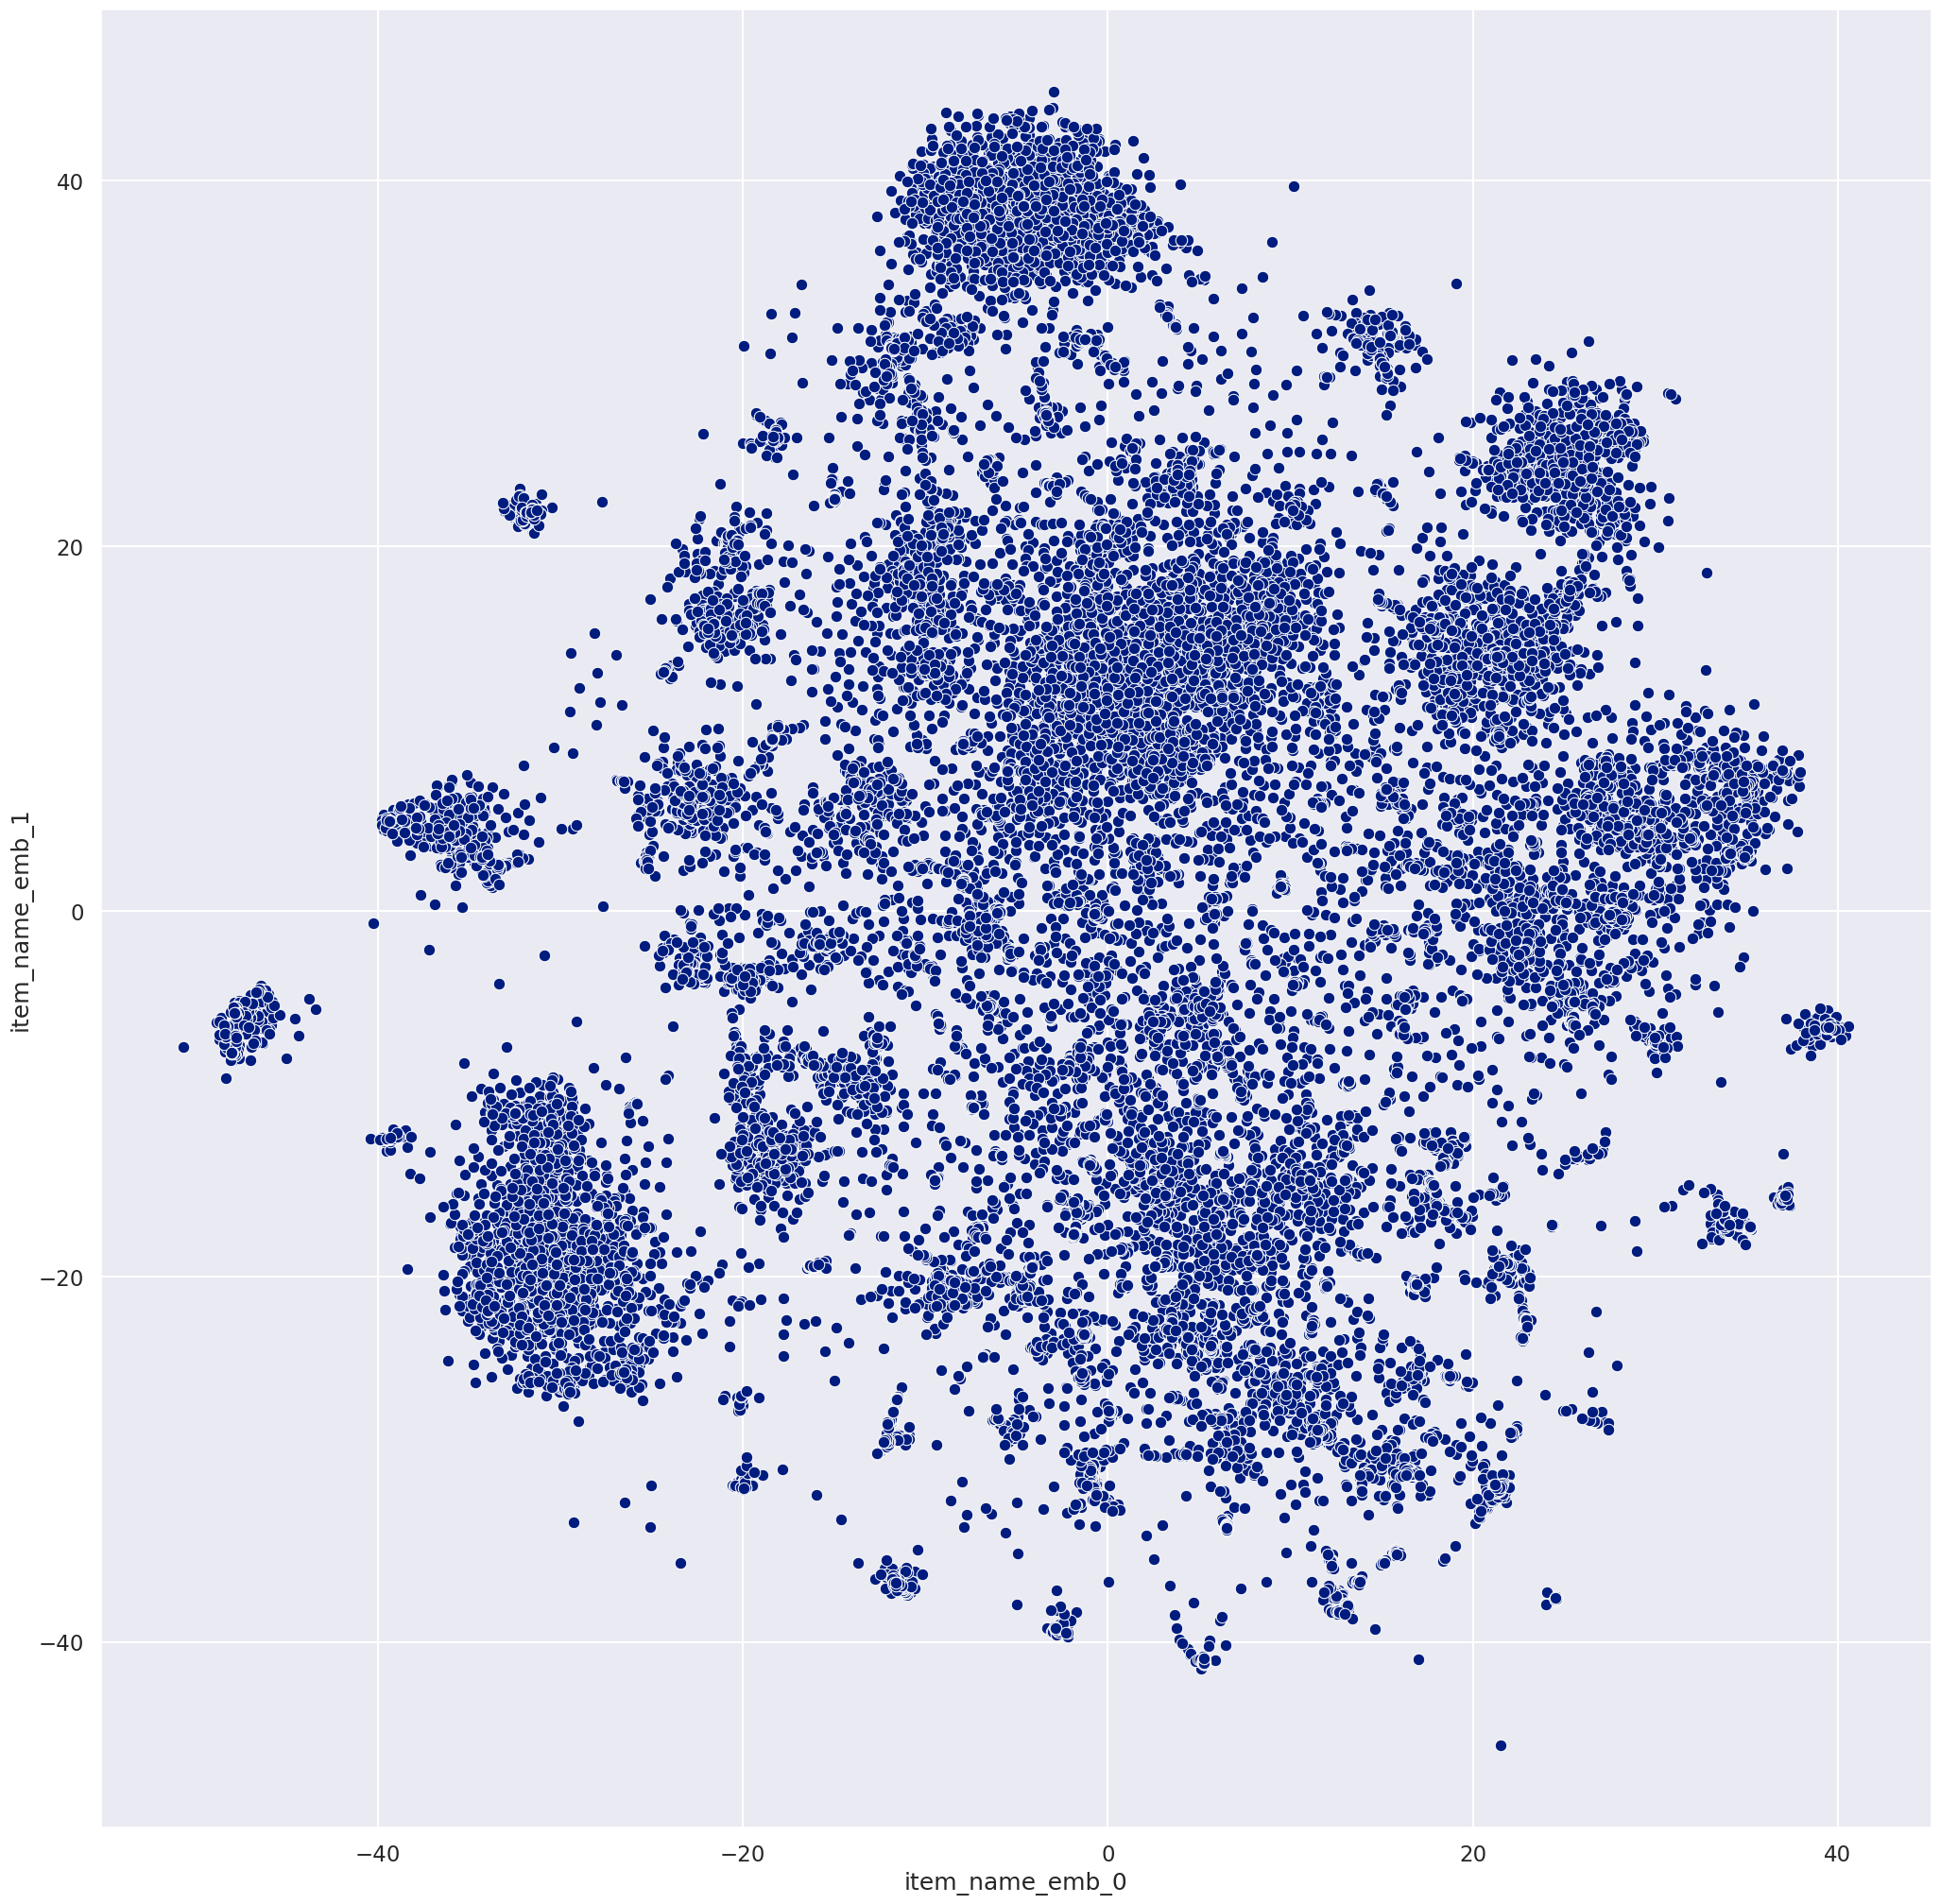

In [51]:
plt.figure(figsize=(25, 25))
sns.scatterplot(data=items[['item_name_emb_0', 'item_name_emb_1']].to_pandas(), x='item_name_emb_0',  y='item_name_emb_1')

According to the distribution plot above, it is possible to distinguish  
separate clusters on the outskirts of the main cloud.  
In the main cloud there are also distinguishable clusters, but they are   
blended between each other and the major amount of points are not in clusters.  

## 10. Dealing with item_category

Let's calculate the length of item_category for both raw and cleaned cases

In [52]:
dataframes['item_categories']["item_category_name_cleaned_length"] = dataframes['item_categories']["item_category_name"].to_pandas().apply(clean_string).apply(len)
dataframes['item_categories']["item_category_name_length"] = dataframes['item_categories']["item_category_name"].to_pandas().apply(len)

Let's encode item_name using BERT and then downsize the embedding using TSNE

In [53]:
dataframes['item_categories'] = encode(df=dataframes['item_categories'], 
                                       column='item_category_name',
                                       perplexity=5,
                                       n_components=2,
                                       is_gpu_accelerated=True,
                                       tsne_method='exact')

[D] [12:41:05.066694] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:71 Data size = (84, 384) with dim = 2 perplexity = 5.000000
[D] [12:41:05.066871] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:109 Getting distances.
[D] [12:41:05.068421] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:144 Now normalizing distances so exp(D) doesn't explode.
[D] [12:41:05.068663] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:152 Searching for optimal perplexity via bisection search.
[D] [12:41:05.070406] /opt/conda/conda-bld/work/cpp/src/tsne/exact_tsne.cuh:62 Now allocating memory for TSNE.
[D] [12:41:05.070551] /opt/conda/conda-bld/work/cpp/src/tsne/exact_tsne.cuh:92 Start gradient updates!
[D] [12:41:05.071402] /opt/conda/conda-bld/work/cpp/src/tsne/exact_tsne.cuh:165 Z at iter = 0 = 0.000140
[D] [12:41:05.095480] /opt/conda/conda-bld/work/cpp/src/tsne/exact_tsne.cuh:165 Z at iter = 100 = 0.003244
[D] [12:41:05.115190] /opt/conda/conda-bld/work/cpp/src/tsne/exact_

<Axes: xlabel='item_category_name_emb_0', ylabel='item_category_name_emb_1'>

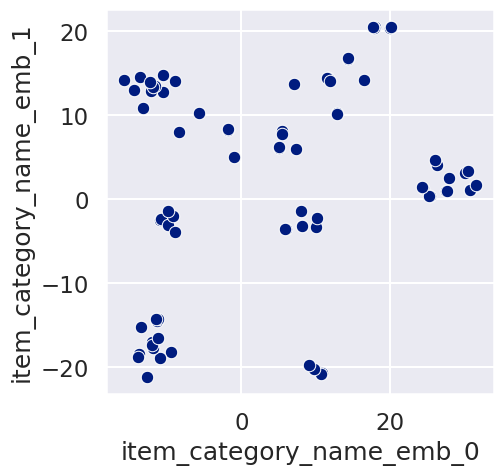

In [54]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=dataframes['item_categories'][['item_category_name_emb_0', 'item_category_name_emb_1']].to_pandas(), 
    x='item_category_name_emb_0',  
    y='item_category_name_emb_1'
)

It can be seen, that it is possible to distinguish certain clusters  
This clusters can be used as a new categorical feature - category_emb_group_id

0it [00:00, ?it/s]

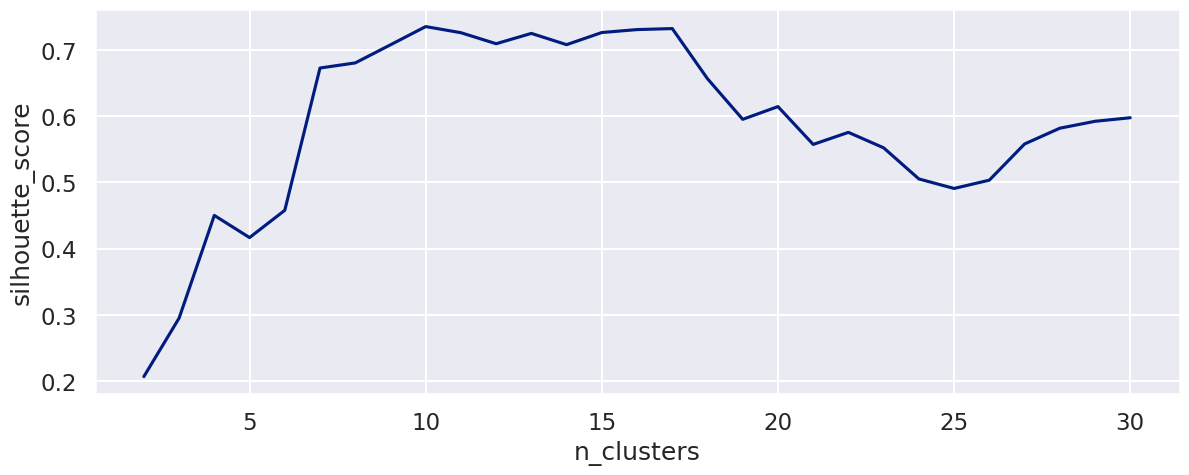

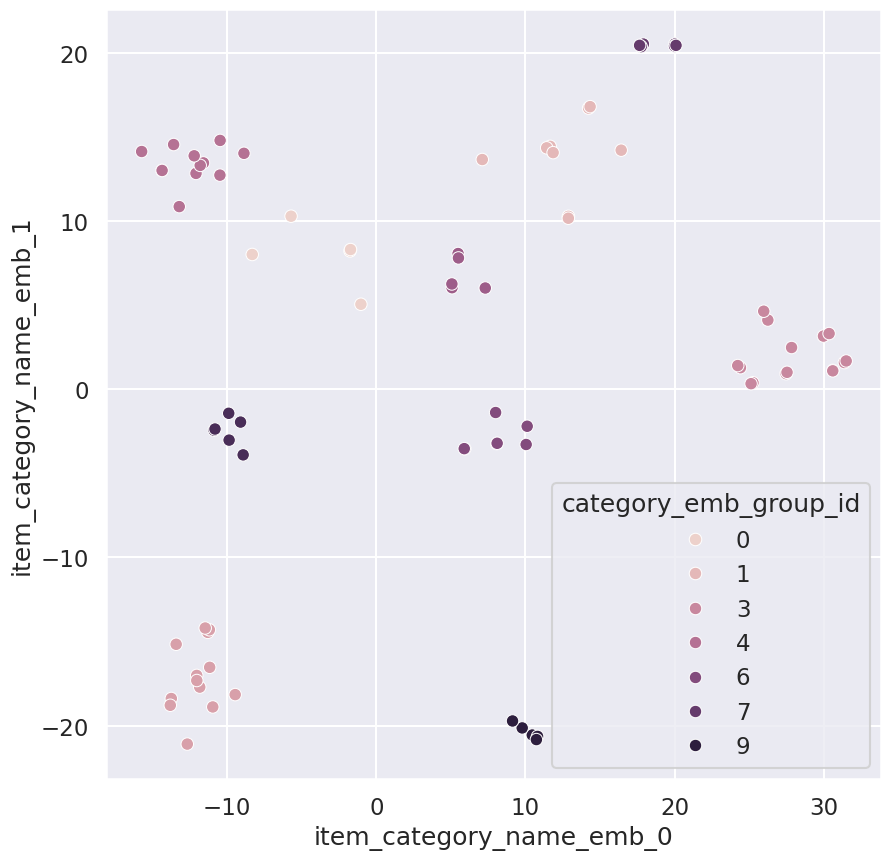

In [55]:
dataframes['item_categories'] = agglomerative_clustering(
    df=dataframes['item_categories'],
    features=['item_category_name_emb_0', 'item_category_name_emb_1'],
    n_clusters_min=2,
    n_clusters_max=30,
    n_clusters_step=1,
    metric='euclidean',
    cluster_feat_name='category_emb_group_id',
    clusters_fig_size=(10, 10)
)

In [56]:
dataframes['item_categories'][['item_category_name', 'category_emb_group_id']].sort_values(by='category_emb_group_id')

,item_category_name,category_emb_group_id
9,Доставка товара,0
79,Служебные,0
81,Чистые носители (шпиль),0
82,Чистые носители (штучные),0
83,Элементы питания,0
0,PC - Гарнитуры/Наушники,1
17,Игровые консоли - Прочие,1
25,Игры - Аксессуары для игр,1
26,Игры Android - Цифра,1
27,Игры MAC - Цифра,1


The resulting groups turned out to be more or less reasonable according to  
silhouette score and the distribution of item_category_name

It is possible to retrieve the following categorical features:
- platform_id
- supercategory_id

In [57]:
platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
}
dataframes['item_categories']['platform_id'] = dataframes['item_categories']['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
dataframes['item_categories']['supercategory_id'] = dataframes['item_categories']['item_category_id'].map(supercat_map)

## 11. Shop

Encoding shop_name using BERT and TSNE

In [58]:
%%time
dataframes['shops'] = encode(df=dataframes['shops'], 
                            column='shop_name',
                            perplexity=5,
                            n_components=2,
                            is_gpu_accelerated=False,
                            tsne_method='exact')

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.025324
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.975303
[t-SNE] KL divergence after 1000 iterations: 0.362222
CPU times: user 2.31 s, sys: 477 ms, total: 2.79 s
Wall time: 3.51 s


<Axes: xlabel='shop_name_emb_0', ylabel='shop_name_emb_1'>

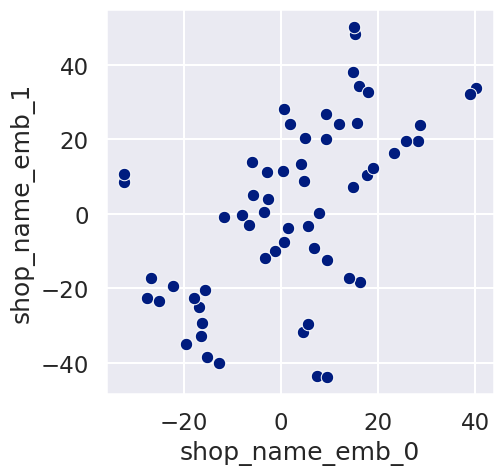

In [59]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=dataframes['shops'][['shop_name_emb_0', 'shop_name_emb_1']].to_pandas(), 
    x='shop_name_emb_0',  
    y='shop_name_emb_1'
)

Grouping embeddings using Agglomerative Clustering

0it [00:00, ?it/s]

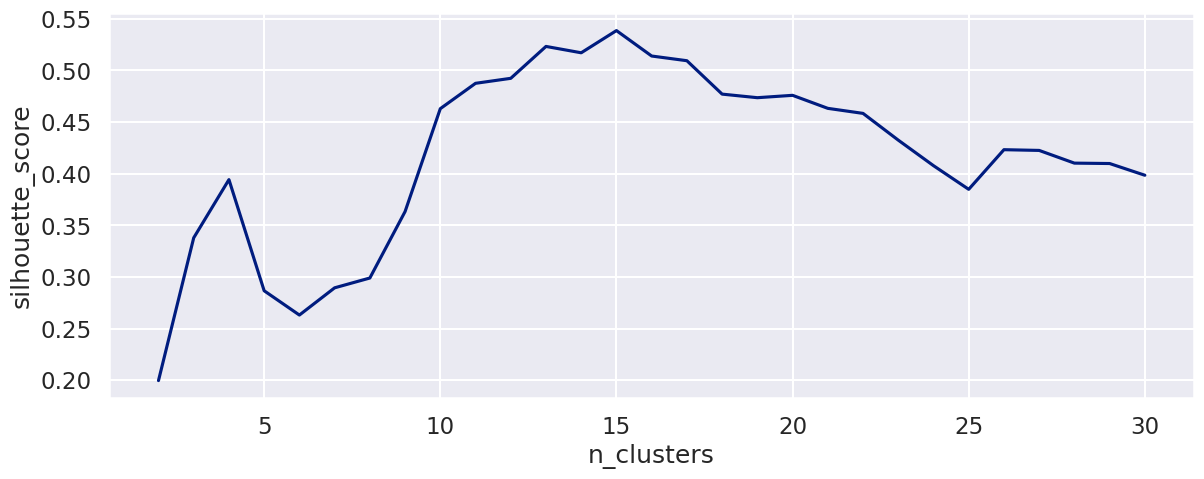

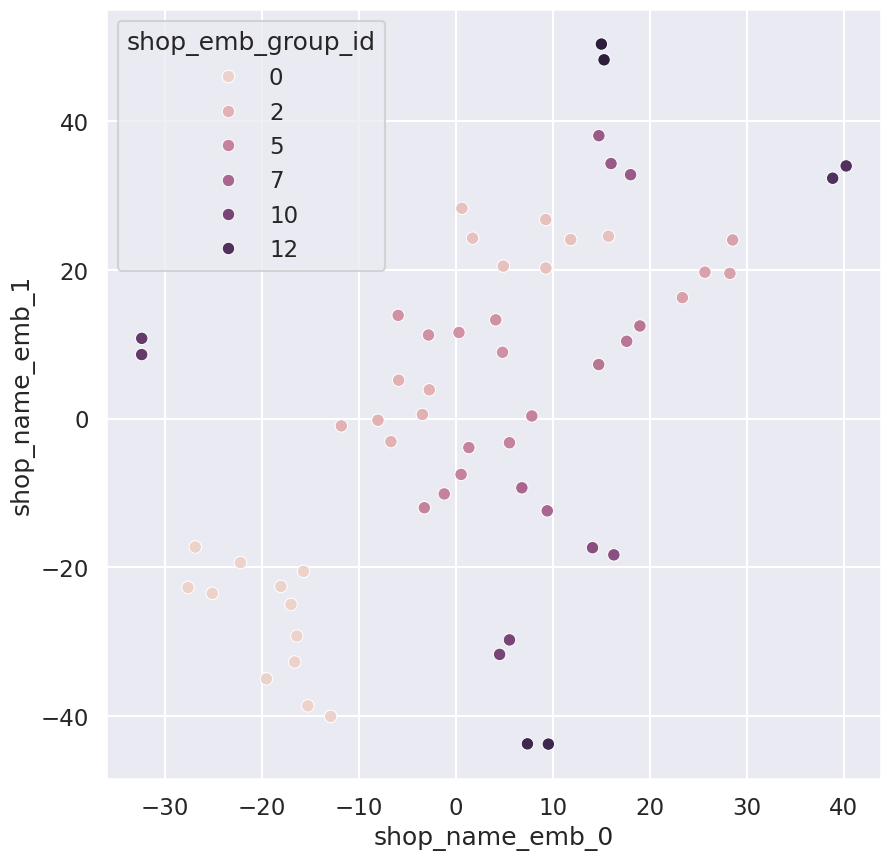

In [60]:
dataframes['shops'] = agglomerative_clustering(
    df=dataframes['shops'],
    features=['shop_name_emb_0', 'shop_name_emb_1'],
    n_clusters_min=2,
    n_clusters_max=30,
    n_clusters_step=1,
    metric='euclidean',
    cluster_feat_name='shop_emb_group_id',
    clusters_fig_size=(10, 10)
)

In [61]:
dataframes['shops'].sort_values(by='shop_emb_group_id')[['shop_name', 'shop_emb_group_id']]

,shop_name,shop_emb_group_id
6,"Воронеж (Плехановская, 13)",0
19,"Курск ТЦ ""Пушкинский""",0
20,"Москва ""Распродажа""",0
22,Москва Магазин С21,0
23,"Москва ТК ""Буденовский"" (пав.А2)",0
24,"Москва ТК ""Буденовский"" (пав.К7)",0
25,"Москва ТРК ""Атриум""",0
26,"Москва ТЦ ""Ареал"" (Беляево)",0
29,"Москва ТЦ ""Новый век"" (Новокосино)",0
30,"Москва ТЦ ""Перловский""",0


New feature: city_code which is calculated by applying label encoding to the city name  
retrieved from shop_name

In [62]:
dataframes['shops'] = dataframes['shops'].to_pandas()
dataframes['shops'].loc[
    dataframes['shops'].shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
] = 'СергиевПосад ТЦ "7Я"'
dataframes['shops']["city"] = dataframes['shops']["shop_name"].str.split(" ").map(lambda x: x[0])
dataframes['shops'].loc[dataframes['shops'].city == "!Якутск", "city"] = "Якутск"
dataframes['shops']["city_code"] = dataframes['shops']["city"].factorize()[0]
dataframes['shops'].drop(['shop_name', 'city'], axis=1, inplace=True)

dataframes['shops'] = cudf.from_dataframe(dataframes['shops'], allow_copy=True)

## 12. Merging

Now, let's add new features obtained for items, item_categories and shops to  
the main dataset

In [63]:
df = (
    df
   .merge(
        items[[
            'item_id',
            'item_name_group',
        ]],
        on="item_id",
        how="left",
    )
)
df_monthly = (
    df_monthly
   .merge(
        items[[
            'item_id',
            'item_name_emb_0',
            'item_name_emb_1',
            'item_name_group',
            'item_name_cleaned_length',
            'item_name_length'
        ]],
        on="item_id",
        how="left",
    )
)
del items

In [64]:
df_monthly = (
    df_monthly
   .merge(
        dataframes['item_categories'][[
            'item_category_id',
            'item_category_name_emb_0',
            'item_category_name_emb_1',
            'item_category_name_cleaned_length',
            'item_category_name_length',
            'category_emb_group_id',
            'platform_id',
            'supercategory_id',
        ]],
        on="item_category_id",
        how="left",
    )
)
del dataframes['item_categories']

In [65]:
df_monthly = (
    df_monthly
   .merge(
        dataframes['shops'][[
            'shop_id',
            'shop_name_emb_0',
            'shop_name_emb_1',
            'shop_emb_group_id',
            'city_code',
        ]],
        on="shop_id",
        how="left",
    )
)
del dataframes['shops']

## 13. Time-related features

It is important to catch the "age" of the item since sales of an item    
depends on whether the item is new and on how long does this item exist in the shop.  
The same is true for the shop - the sales might differ if the shop is old or new

Therefore, shop_age, item_age and new_item features are introduced
Later these features will be used for the calculation of windowed aggregations and  
target encodings

In [66]:
def add_feature_age(df: cudf.DataFrame, feature: str, new_feature: str) -> cudf.DataFrame:
    df = (
        df
        .merge(
            df
            .groupby([feature])["date_block_num"]
            .min()
            .rename(new_feature)
            .reset_index(),
            on=feature,
            how="left",
        )
    )
    df[new_feature] = df["date_block_num"] - df[new_feature]
    return df

def add_month_info(df, df_monthly):
    dates = df.groupby('date_block_num')['date'].first().to_frame()
    dates['month_start'] = cudf.to_datetime(
        dates['date'].dt.year.astype(str) 
        + '-' 
        + dates['date'].dt.month.astype(str).str.zfill(2) 
        + '-01'
    )
    dates['month_end'] = dates['month_start'] + cudf.DateOffset(months=1) - cudf.DateOffset(days=1)
    dates['month_length'] = (dates['month_end'] - dates['month_start']).dt.days + 1
    df_monthly = df_monthly.merge(dates, left_on='date_block_num', how='left', right_index=True)
    return df_monthly


def add_first_occurence_info(df, df_monthly):
    groups = [
        ['shop_id'],
        ['item_id'],
        ['item_name_group'],
        ["shop_id", "item_id"]
    ]
    for group in groups:
        df_monthly = df_monthly.merge(
            df.groupby(group)['date'].min().rename(f"{'.'.join(group)}.first_date"),
            left_on=group,
            how='left',
            right_index=True
        )
    return df_monthly

def add_last_sale_days(df, df_monthly):
    last_shop_item_dates = []
    for dbn in range(1, 35):
        lsid_temp = (
            df.query(f"date_block_num < {dbn}")
            .groupby(["shop_id", "item_id"])
            .date.max()
            .rename("last_shop_item_sale_date")
            .reset_index()
        )
        lsid_temp["date_block_num"] = dbn
        last_shop_item_dates.append(lsid_temp)

    last_shop_item_dates = cudf.concat(last_shop_item_dates)
    df_monthly = df_monthly.merge(
        last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
    )

    df_monthly['last_shop_item_sale_days'] = (df_monthly["month_start"] - df_monthly['last_shop_item_sale_date']).dt.days
    df_monthly.loc[df_monthly["last_shop_item_sale_days"] > 2000, "last_shop_item_sale_days"] = 9999
    df_monthly["last_shop_item_sale_days"] = df_monthly["last_shop_item_sale_days"].fillna(9999)

    df_monthly.drop(columns=["last_shop_item_sale_date"], inplace=True)
    return df_monthly


def add_time_features(df, df_monthly):

    # Adding info about submission data to the df dataframe
    submission_part = df_monthly.loc[df_monthly.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    submission_part = submission_part.assign(
        date=cudf.to_datetime("2015-11-30"), item_price=0, item_cnt_day=0, item_revenue_day=0,
    )
    df = cudf.concat([df, submission_part], axis=0)
    del submission_part

    # Adding month start, end, length to df_monthly
    df_monthly = add_month_info(df, df_monthly)

    # Adding info about first occurence of each item, shop, item group ...
    df_monthly = add_first_occurence_info(df, df_monthly)

    # Number of days shop (item) has been opened (saled) since the first occurence
    df_monthly["shop_open_days"] = (df_monthly["month_end"] - df_monthly["shop_id.first_date"]).dt.days + 1
    df_monthly["item_first_sale_days"] = (df_monthly["month_end"] - df_monthly["item_id.first_date"]).dt.days + 1
    
    # Number of days an item has been sold in a shop in each month.
    df_monthly["item_in_shop_days"] = df_monthly[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1)

    # Average number of items sold in each month per item and shop
    df_monthly["item_cnt_day_avg"] = df_monthly["item_cnt_month"] / df_monthly["item_in_shop_days"]

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    df_monthly["shop_open_days"] = (df_monthly["month_start"] - df_monthly["shop_id.first_date"]).dt.days
    df_monthly["first_item_sale_days"] = (df_monthly["month_start"] - df_monthly["item_id.first_date"]).dt.days
    df_monthly["first_shop_item_sale_days"] = (df_monthly["month_start"] - df_monthly["shop_id.item_id.first_date"]).dt.days
    df_monthly["first_name_group_sale_days"] = (df_monthly["month_start"] - df_monthly["item_name_group.first_date"]).dt.days

    df_monthly["shop_open_days"] = df_monthly["shop_open_days"].fillna(0).clip(lower=0)
    df_monthly["first_item_sale_days"] = (
        df_monthly["first_item_sale_days"].fillna(0).clip(lower=0).replace(0, 9999)
    )
    df_monthly["first_shop_item_sale_days"] = (
        df_monthly["first_shop_item_sale_days"].fillna(0).clip(lower=0).replace(0, 9999)
    )
    df_monthly["first_name_group_sale_days"] = (
        df_monthly["first_name_group_sale_days"].fillna(0).clip(lower=0).replace(0, 9999)
    )
    
    # Add days since last sale
    df_monthly = add_last_sale_days(df, df_monthly)

    # Month features
    df_monthly["month"] = df_monthly["month_start"].dt.month

    # Dropping auxiliary columns
    df_monthly.drop(
        columns=[
            'date',
            "month_start",
            "month_end",
            "month_length",
            "shop_id.first_date",
            "item_id.first_date",
            "item_name_group.first_date",
            "item_in_shop_days",
            "shop_id.item_id.first_date",
        ],
        inplace=True,
    )

    return df_monthly

In [67]:
df_monthly = add_feature_age(df=df_monthly, feature='item_id', new_feature='item_age')
df_monthly = add_feature_age(df=df_monthly, feature='shop_id', new_feature='shop_age')
df_monthly["new_item"] = df_monthly["item_age"] == 0
df_monthly = add_time_features(df, df_monthly)

## 14. Saving data

Converting types to save RAM

In [68]:
reduce_size(df_monthly)

  0%|          | 0/45 [00:00<?, ?it/s]

Saving the current state of the main dataset

In [69]:
df_monthly.to_parquet('../data/artifacts/df1.parquet', index=False)

# II

## 1. Reading data and converting types

In [2]:
df_monthly = cudf.read_parquet('../data/artifacts/df1.parquet')

## 2. Number of unique item features

In [3]:
def uniques(df, groupers, name, new_items=False):
    if new_items:
        s = (
            df.query('new_item == True')
            .groupby(groupers)['item_id']
            .nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = df.groupby(groupers)['item_id'].nunique().rename(name).reset_index()
    df = df.merge(s, on=groupers, how="left")
    df[name] = df[name].fillna(0)
    return df

groups = {
    'unique_items_month': ['date_block_num'],
    'unique_items_month.per.item_category_id': ["date_block_num", "item_category_id"],
    'unique_items_month.per.item_name_group': ["date_block_num", "item_name_group"],
    'unique_items_month.per.item_name_group.item_category_id': ["date_block_num", "item_category_id", "item_name_group"],
    'new_items_month': ['date_block_num'],
    'new_items_month.per.item_category_id': ["date_block_num", "item_category_id"],
    'new_items_month.per.item_name_group': ["date_block_num", "item_name_group"],
    'new_items_month.per.item_name_group.item_category_id': ["date_block_num", "item_category_id", "item_name_group"],
}

for name, group in tqdm(groups.items()):
    if 'new' in name:
        df_monthly = uniques(df_monthly, group, name, True)
    else:
        df_monthly = uniques(df_monthly, group, name, False)

df_monthly["unique_items_ratio_month.per.item_category_id"] = (
    df_monthly["unique_items_month.per.item_category_id"] / df_monthly["unique_items_month"]
).astype('float32')
df_monthly["new_items_ratio_month.per.item_name_group"] = (
    df_monthly["new_items_month.per.item_name_group"] / df_monthly["unique_items_month.per.item_name_group"]
).astype('float32')

  0%|          | 0/8 [00:00<?, ?it/s]

## 3. Lag Features

Since the task is related to predicting the behaviour of a time series  
it is essential to introduce lag features for the target feature and also  
some other ones  

Since the time range is 33 month and a classic ML model will be used,   
getting lags up to 3 month will be enough. In case of models like ARIMA  
more lags would be requried

In [4]:
from sales_project.utils import add_lag

df_monthly = df_monthly.sort_values(by=['date_block_num', "shop_id", "item_id"], ascending=True)

df_monthly = add_lag(
    df=df_monthly,
    lags=[1, 2, 3],
    feat_to_lag='item_cnt_month',
    timestamp_col='date_block_num',
    grouping_cols=["shop_id", "item_id"],
    dtype='float32'
)

df_monthly = add_lag(
    df=df_monthly,
    lags=[1, 2, 3],
    feat_to_lag='item_revenue_month',
    timestamp_col='date_block_num',
    grouping_cols=["shop_id", "item_id"],
    dtype='float32'
)

df_monthly = add_lag(
    df=df_monthly,
    lags=[1, 2, 3],
    feat_to_lag='item_cnt_day_avg',
    timestamp_col='date_block_num',
    grouping_cols=["shop_id", "item_id"],
    dtype='float32'
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## 4. Target Encoding

A lot of categorical and discrete features have been obtained previously.  
These features can't be directly used unless they are encoded.  
Label encoding or One-hot encoding are not the options since for the most  
features the number of unique values is rather big and it is not   
possible to introduce the order to the values.  
Moreover, such encoding are quite simple.

Thefore, a more elaborated encoding method will be used - target encoding  
Since the task is related to time series, 1-month lagged encoding will be  
calculated.

In [5]:
for grouping_cols, aggfunc in tqdm([
    [['item_name_group'], 'sum'],
    [['item_name_group'], 'mean'],
    [['item_id'], 'mean'],
    [['platform_id'], 'mean'],
    [['supercategory_id'], 'mean'],
    [["item_category_id", "new_item"], 'mean'],
    [["shop_id", "item_category_id"], 'mean'],
    [['shop_emb_group_id', 'item_id'], 'mean'],
    [["city_code", "item_id"], 'mean'],
    [["city_code", "item_name_group"], 'mean'],
]):
    df_monthly = target_encoder(
        df=df_monthly,
        timestamp_col='date_block_num',
        grouping_cols=grouping_cols, 
        target_col_name='item_cnt_month',
        aggfunc=aggfunc,
        lags=[1],
        dtype='float32'
    )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
for grouping_cols, aggfunc in tqdm([
    [['item_name_group'], 'sum'],
    [['item_name_group'], 'mean'],
    [['item_id'], 'mean'],
    [['platform_id'], 'mean'],
    [['supercategory_id'], 'mean'],
    [["item_category_id", "new_item"], 'mean'],
    [["shop_id", "item_category_id"], 'mean'],
    [['shop_emb_group_id', 'item_id'], 'mean'],
    [["city_code", "item_id"], 'mean'],
    [["city_code", "item_name_group"], 'mean'],
]):
    df_monthly = target_encoder(
        df=df_monthly,
        timestamp_col='date_block_num',
        grouping_cols=grouping_cols, 
        target_col_name='item_cnt_day_avg',
        aggfunc=aggfunc,
        lags=[1],
        dtype='float32'
    )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## 5. Percentage change

In this section, a proportional change  
in mean sales count is calculated for a specific grouping for a specific time interval,  
e.g. increase / decrease in mean sales of an item between the last 2 months.

In [7]:
def add_pct_change(
    df: cudf.DataFrame,
    grouping_cols: list[str],
    target_col: str,
    timestamp_col: str,
    aggfunc: str = "mean",
    periods: list[int] = [1],
    lag: int = 1,
    clip_value: int | None = None,
):
    dat = (
        df
        .groupby([timestamp_col] + grouping_cols)
        .agg({target_col: aggfunc})
        .fillna(0)
    ).astype("float32")
    dat.reset_index(inplace=True)

    for feat in grouping_cols:
        firsts = df.groupby(feat)[timestamp_col].min().rename("firsts")
        dat = dat.merge(firsts, left_on=feat, right_index=True, how="left")
        dat.loc[dat[timestamp_col] < dat["firsts"], target_col] = None
        del dat["firsts"]

    dat = dat.to_pandas()
    
    for period in periods:
        feat_name = ".".join(
            grouping_cols + [target_col] + [aggfunc] + ["delta"] + [str(period)] + [f"lag.{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat[feat_name] = (
            dat
            .groupby(grouping_cols)[target_col]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
        )
        if clip_value is not None:
            dat[feat_name] = dat[feat_name].clip(lower=-clip_value, upper=clip_value)
        dat[feat_name] = dat[feat_name].astype("float32")
    del dat[target_col]
    dat[timestamp_col] += lag
    dat = cudf.from_pandas(dat)
    df = df.merge(dat, on=[timestamp_col] + grouping_cols, how="left")
    del dat
    return df

In [8]:
df_monthly = add_pct_change(
    df=df_monthly,
    grouping_cols=["item_id"], 
    target_col="item_cnt_month", 
    timestamp_col='date_block_num',
    clip_value=3
)

df_monthly = add_pct_change(
    df=df_monthly,
    grouping_cols=["item_category_id"], 
    target_col="item_cnt_month", 
    timestamp_col='date_block_num',
    clip_value=3
)

df_monthly = add_pct_change(
    df=df_monthly,
    grouping_cols=["item_name_group"], 
    target_col="item_cnt_month", 
    timestamp_col='date_block_num',
    clip_value=3,
)

df_monthly = add_pct_change(
    df=df_monthly,
    grouping_cols=["item_category_id"], 
    target_col="item_cnt_month", 
    timestamp_col='date_block_num',
    lag=12,
    clip_value=3,
)

Adding feature item_id.item_cnt_month.mean.delta.1.lag.1
Adding feature item_category_id.item_cnt_month.mean.delta.1.lag.1
Adding feature item_name_group.item_cnt_month.mean.delta.1.lag.1
Adding feature item_category_id.item_cnt_month.mean.delta.1.lag.12


## 6. Saving data

In [9]:
reduce_size(df_monthly)

  0%|          | 0/88 [00:00<?, ?it/s]

In [10]:
df_monthly.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10816506 entries, 0 to 10816505
Data columns (total 88 columns):
 #   Column                                                   Dtype
---  ------                                                   -----
 0   shop_id                                                  uint8
 1   item_id                                                  uint16
 2   date_block_num                                           uint8
 3   item_cnt_month                                           float32
 4   item_price_mean                                          float32
 5   log1p_item_price_mean                                    float32
 6   item_revenue_month                                       float32
 7   item_revenue_month_mean                                  float32
 8   log1p_item_revenue_month_mean                            float32
 9   item_category_id                                         uint8
 10  last_item_price                                  

In [11]:
df_monthly = df_monthly.to_pandas()

In [12]:
df_monthly.to_parquet('../data/artifacts/df2.parquet', index=False)

# III.

## 1. Reading data and downgrading types

In [2]:
df_monthly = cudf.read_parquet('../data/artifacts/df2.parquet')

In [9]:
for col in df_monthly.columns:
    n = df_monthly[col].isnull().sum()
    if n > 0:
        print(col, f"{round(n / len(df_monthly) * 100)}")

item_cnt_month 2
item_price_mean 2
log1p_item_price_mean 2
item_revenue_month 2
item_revenue_month_mean 2
log1p_item_revenue_month_mean 2
last_item_price 9
last_item_revenue_day 9
last_log1p_item_price 9
last_log1p_item_revenue_day 9
last_norm_diff_cat_price 9
last_norm_diff_cat_revenue 9
last_norm_diff_cat_log1p_price 9
last_norm_diff_cat_log1p_revenue 9
item_cnt_day_avg 2
item_cnt_month.lag.1 3
item_cnt_month.lag.2 7
item_cnt_month.lag.3 10
item_revenue_month.lag.1 3
item_revenue_month.lag.2 7
item_revenue_month.lag.3 10
item_cnt_day_avg.lag.1 3
item_cnt_day_avg.lag.2 7
item_cnt_day_avg.lag.3 10
item_name_group.item_cnt_month.sum.lag.1 3
item_name_group.item_cnt_month.mean.lag.1 3
item_id.item_cnt_month.mean.lag.1 3
platform_id.item_cnt_month.mean.lag.1 3
supercategory_id.item_cnt_month.mean.lag.1 3
item_category_id.new_item.item_cnt_month.mean.lag.1 3
shop_id.item_category_id.item_cnt_month.mean.lag.1 3
shop_emb_group_id.item_id.item_cnt_month.mean.lag.1 3
city_code.item_id.item_cnt

## 2. Windowed aggregations

In this section, certain aggregations (mean and sum) via rolling and expanding windows  
are calculated for various groups of categorical and discrete features

In [4]:
grouping_cols = [
    "shop_id",
    "item_id",
    "item_name_group",
    "item_category_id",
    "item_age",
    'new_item',
    "category_emb_group_id",
    "platform_id",
    "supercategory_id",
    "shop_emb_group_id",
]
grouping_cols2 = [
    v
    for k in [
        [[grouping_cols[it1], grouping_cols[it2]] for it2 in range(it1+1, len(grouping_cols))]
        for it1 in range(len(grouping_cols))
    ]
    for v in k
]

grouping_cols2 = [
    ['shop_id', 'item_id'],
    ['shop_id', 'item_name_group'],
    ['shop_id', 'item_category_id'],
    # ['shop_id', 'item_age'],
    # ['shop_id', 'new_item'],
    ['shop_id', 'category_emb_group_id'],
    # ['shop_id', 'platform_id'],
    # ['shop_id', 'supercategory_id'],
    # ['shop_id', 'shop_emb_group_id'],
    ['item_id', 'item_age'],
    ['item_id', 'new_item'],
    ['item_id', 'shop_emb_group_id'],
    # ['item_id', 'item_name_group'],
    ['item_id', 'item_category_id'],
    ['item_id', 'category_emb_group_id'],
    # ['item_id', 'supercategory_id'],
    # ['item_id', 'platform_id'],
    ['item_name_group', 'item_category_id'],
    ['item_name_group', 'item_age'],
    ['item_name_group', 'new_item'],
    ['item_name_group', 'category_emb_group_id'],
    # ['item_name_group', 'platform_id'],
    # ['item_name_group', 'supercategory_id'],
    ['item_name_group', 'shop_emb_group_id'],
    ['item_category_id', 'item_age'],
    ['item_category_id', 'new_item'],
    # ['item_category_id', 'category_emb_group_id'],
    ['item_category_id', 'shop_emb_group_id'],
    # ['item_category_id', 'supercategory_id'],
    # ['item_category_id', 'platform_id'],
    ['item_age', 'new_item'],
    ['item_age', 'category_emb_group_id'],
    # ['item_age', 'platform_id'],
    # ['item_age', 'supercategory_id'],
    ['item_age', 'shop_emb_group_id'],
    ['new_item', 'category_emb_group_id'],
    # ['new_item', 'platform_id'],
    # ['new_item', 'supercategory_id'],
    ['new_item', 'shop_emb_group_id'],
    # ['category_emb_group_id', 'platform_id'],
    # ['category_emb_group_id', 'supercategory_id'],
    ['category_emb_group_id', 'shop_emb_group_id'],
    # ['platform_id', 'shop_emb_group_id'],
    # ['platform_id', 'supercategory_id']
    # ['supercategory_id', 'shop_emb_group_id']
]

grouping_cols3 = [
    ["shop_id", "item_category_id", "item_age"],
    ["shop_id", "item_category_id", "new_item"],
    ["shop_id", "item_name_group", "new_item"],
    ["shop_id", "supercategory_id", "new_item"],
    ["shop_id", "platform_id", "new_item"],
    ["shop_emb_group_id", "item_category_id", "item_age"],
    ["shop_emb_group_id", "item_category_id", "new_item"],
    ["shop_emb_group_id", "item_name_group", "new_item"],
    ["shop_emb_group_id", "supercategory_id", "new_item"],
    ["shop_emb_group_id", "platform_id", "new_item"],
]

combinations = []
for cols in grouping_cols + grouping_cols2:
    cols_ = cols if type(cols)==list else [cols]
    combinations.append(cols_)
    # combinations.append([cols_, "rolling", 12, True])
    # combinations.append([cols_, "expanding", None, True])
    # combinations.append([cols_, "ewm", 1, True])

In [5]:
new_columns = []
for k, (kind, window) in enumerate([
    ["rolling", 12],
    ["expanding", None],
    ["ewm", 1],
]):
    for it, cols in enumerate(tqdm(combinations)):
        aggregations, feat_name = aggregate(
            df=df_monthly,
            timestamp_feat='date_block_num',
            grouping_feats=cols,
            feat_to_agg='item_cnt_month',
            reshaping_aggfunc="mean",
            rolling_aggfunc="mean",
            window=window,
            dtype="float32",
            lag_offset=0,
            requires_reshaping=True,
            kind=kind,
        )
        if 'date_block_num' in aggregations.columns:
            df_monthly = df_monthly.merge(
                aggregations,
                on=['date_block_num'] + cols,
                how="left",
            )
        else:
            df_monthly = df_monthly.merge(
                aggregations,
                on=cols,
                how="left",
            )
        new_columns.append(feat_name)
    # print(f'Saving group {(k + 1)} ...')
    # df_monthly[new_columns+['date_block_num']].query('date_block_num == 34').to_csv(
    #     f'../data/artifacts/df_submission_{(k + 1)}.csv', 
    #     index=False,
    # )
    # df_monthly[new_columns+['date_block_num']].query('date_block_num < 34').to_csv(
    #     f'../data/artifacts/df_train_{(k + 1)}.csv', 
    #     index=False, 
    #     chunksize=100000
    # )
    # df_monthly.drop(new_columns, axis=1, inplace=True)
    # new_columns = []

  0%|          | 0/33 [00:00<?, ?it/s]

Creating feature "shop_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "item_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "item_name_group.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "item_category_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "item_age.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "new_item.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "category_emb_group_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "platform_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "supercategory_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "shop_emb_group_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "shop_id.item_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "shop_id.item_name_group.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "shop_id.item_category_id.item_cnt_month.mean.rolling.mean.win.12"
Creating feature "shop_id.catego

  0%|          | 0/33 [00:00<?, ?it/s]

Creating feature "shop_id.item_cnt_month.mean.expanding.mean"
Creating feature "item_id.item_cnt_month.mean.expanding.mean"
Creating feature "item_name_group.item_cnt_month.mean.expanding.mean"
Creating feature "item_category_id.item_cnt_month.mean.expanding.mean"
Creating feature "item_age.item_cnt_month.mean.expanding.mean"
Creating feature "new_item.item_cnt_month.mean.expanding.mean"
Creating feature "category_emb_group_id.item_cnt_month.mean.expanding.mean"
Creating feature "platform_id.item_cnt_month.mean.expanding.mean"
Creating feature "supercategory_id.item_cnt_month.mean.expanding.mean"
Creating feature "shop_emb_group_id.item_cnt_month.mean.expanding.mean"
Creating feature "shop_id.item_id.item_cnt_month.mean.expanding.mean"
Creating feature "shop_id.item_name_group.item_cnt_month.mean.expanding.mean"
Creating feature "shop_id.item_category_id.item_cnt_month.mean.expanding.mean"
Creating feature "shop_id.category_emb_group_id.item_cnt_month.mean.expanding.mean"
Creating feat

  0%|          | 0/33 [00:00<?, ?it/s]

Creating feature "shop_id.item_cnt_month.mean.ewm.mean"
Creating feature "item_id.item_cnt_month.mean.ewm.mean"
Creating feature "item_name_group.item_cnt_month.mean.ewm.mean"
Creating feature "item_category_id.item_cnt_month.mean.ewm.mean"
Creating feature "item_age.item_cnt_month.mean.ewm.mean"
Creating feature "new_item.item_cnt_month.mean.ewm.mean"
Creating feature "category_emb_group_id.item_cnt_month.mean.ewm.mean"
Creating feature "platform_id.item_cnt_month.mean.ewm.mean"
Creating feature "supercategory_id.item_cnt_month.mean.ewm.mean"
Creating feature "shop_emb_group_id.item_cnt_month.mean.ewm.mean"
Creating feature "shop_id.item_id.item_cnt_month.mean.ewm.mean"
Creating feature "shop_id.item_name_group.item_cnt_month.mean.ewm.mean"
Creating feature "shop_id.item_category_id.item_cnt_month.mean.ewm.mean"
Creating feature "shop_id.category_emb_group_id.item_cnt_month.mean.ewm.mean"
Creating feature "item_id.item_age.item_cnt_month.mean.ewm.mean"
Creating feature "item_id.new_it

In [6]:
df_monthly.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10816506 entries, 0 to 10816505
Columns: 177 entries, shop_id to category_emb_group_id.shop_emb_group_id.item_cnt_month.mean.ewm.mean
dtypes: bool(1), float32(149), uint16(10), uint8(17)
memory usage: 6.6 GB


## 3. Saving data

In [7]:
auxiliary_feats = [
    'item_price_mean',
    'log1p_item_price_mean',
    'item_revenue_month',
    'item_revenue_month_mean',
    'log1p_item_revenue_month_mean',
    'item_category_id',
    'item_age',
    'new_item',
    'shop_age',
    'item_name_group',
    'category_emb_group_id',
    'platform_id',
    'supercategory_id',
    'shop_emb_group_id',
    'city_code',
    'item_first_sale_days',
    'item_cnt_day_avg',
    # 'unique_items_month',
    # 'name_group_unique_month',
    # 'name_group_new_unique_month',
    # 'name_group_cat_unique_month',
    # 'name_group_new_cat_unique_month',
    # 'unique_items_cat',
    # 'new_items_cat',
    # 'new_items_month',
    # 'cat_items_proportion',
    # 'name_group_new_proportion_month',
]
df_monthly.drop(auxiliary_feats, axis=1, inplace=True, errors='ignore')

In [8]:
df_monthly.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10816506 entries, 0 to 10816505
Columns: 169 entries, shop_id to category_emb_group_id.shop_emb_group_id.item_cnt_month.mean.ewm.mean
dtypes: float32(149), uint16(9), uint8(11)
memory usage: 6.5 GB


In [30]:
df_monthly.query('date_block_num == 34').to_parquet(
    f'../data/artifacts/df_submission.parquet', 
    index=False,
)

In [9]:
pdf = pd.DataFrame()
for col in tqdm(df_monthly.columns):
    pdf[col] = df_monthly[[
        'date_block_num', col
    ]].query('date_block_num < 34')[col].to_pandas()
    if col != 'date_block_num':
        del df_monthly[col]

  0%|          | 0/169 [00:00<?, ?it/s]

In [13]:
pdf.to_parquet(
    f'../data/artifacts/df3.parquet', 
    index=False,
)